In [1]:
!pip install torchsummary
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=9d1dabb2ce2c95d17150cddf034d5b3b4c7650f62b2e5d649c23864231c79d57
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
from imutils import paths
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from tqdm import tqdm
import numpy as np
import cv2
import os
import time
import copy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/input/coltech101/101_ObjectCategories',  
    transform=transform,
)
dataset_size = len(dataset)
train_ratio = 0.8  
train_size = int(train_ratio * dataset_size)
valid_size = dataset_size - train_size
batch_size = 128
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)
) 

In [6]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 训练集需要打乱
    num_workers=2  # 多线程加载（可选）
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,  # 验证集无需打乱
    num_workers=2
)

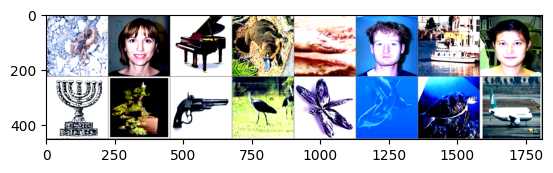

In [7]:
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return

x, y = next(iter(DataLoader(train_loader.dataset, batch_size=16, shuffle=True)))
out = torchvision.utils.make_grid(x)
imgshow(out)

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [33]:
def fit(model, dataloader, optimizer):

   # print('-' * 5, 'Training', '-' * 5)

    # Set model to training mode
    model.train()
    # Variables to track training procees (loss and accuracy)
    running_loss = 0.0
    running_correct = 0

    # Iterate over data
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(data)

        # Tracking history
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += torch.sum(preds == target.data).item()

        # Compute gradients
        loss.backward()
        # Adjust learning weights
        optimizer.step()

    # Gather performance report
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)

    #print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")

    return loss, accuracy

In [34]:
def validate(model, dataloader):

    #print('-' * 5, 'Validating', '-' * 5)

    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        # Iterate over data
        for i, data in tqdm(enumerate(dataloader), total=int(len(valid_dataset)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += torch.sum(preds == target.data).item()
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        #print(f'Validation Loss: {loss:.4f}, Val Acc: {accuracy:.4f}')

        return loss, accuracy

In [36]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    start = time.time()
    # Iterate through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        #print('-' * 10)

        train_epoch_loss, train_epoch_accuracy = fit(model, dataloaders['train'], optimizer)
        val_epoch_loss, val_epoch_accuracy = validate(model, dataloaders['val'])
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)
        if val_epoch_accuracy > best_acc:
                best_acc = val_epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                #print(f'New best accuracy: {best_acc}. The best model was updated.')

    end = time.time()
    print(f'Training complete in {(end-start)/60} minutes')

    print(f'Best Validation Accuracy: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }

    return model, history

In [41]:
from torchvision import models

class AlexNet(nn.Module):
    def __init__(self, num_classes=101, pretrained = False):
        super(AlexNet, self).__init__()
        self.alexnet = models.alexnet(pretrained=pretrained)
        self.alexnet.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.alexnet(x)

class ResNet18(nn.Module):
    def __init__(self, num_classes=101, pretrained=False):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=pretrained)
        self.resnet18.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet18(x)

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, title="Training History"):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'b-', label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r-', label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# **Experiment 1:**
## **Compare Random Initial/Pretrained Models for Alexnet:**

In [55]:
'''
Experiment 1:
Compare Random Initial/Pretrained Models for Alexnet
'''
model = AlexNet().to(device)
# Check model architecture
summary(model, (3, 224, 224))
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model, history_model = train_model(model=model,
                                dataloaders={'train':train_loader, 'val':valid_loader},
                                criterion=criterion,
                                optimizer=optimizer,
                                num_epochs=15)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

55it [00:14,  3.73it/s]                        
14it [00:04,  3.16it/s]                        

Epoch 2/15



55it [00:14,  3.69it/s]                        
14it [00:03,  3.62it/s]                        

Epoch 3/15



55it [00:15,  3.51it/s]                        
14it [00:03,  3.56it/s]                        

Epoch 4/15



55it [00:15,  3.51it/s]                        
14it [00:03,  3.57it/s]                        

Epoch 5/15



55it [00:16,  3.43it/s]                        
14it [00:03,  3.63it/s]                        

Epoch 6/15



55it [00:15,  3.62it/s]                        
14it [00:03,  3.77it/s]                        

Epoch 7/15



55it [00:14,  3.71it/s]                        
14it [00:03,  3.51it/s]                        

Epoch 8/15



55it [00:15,  3.65it/s]                        
14it [00:03,  3.64it/s]                        

Epoch 9/15



55it [00:14,  3.79it/s]                        
14it [00:03,  3.66it/s]                        

Epoch 10/15



55it [00:14,  3.77it/s]                        
14it [00:03,  3.56it/s]                        

Epoch 11/15



55it [00:14,  3.76it/s]                        
14it [00:03,  3.55it/s]                        

Epoch 12/15



55it [00:15,  3.46it/s]                        
14it [00:03,  3.54it/s]                        

Epoch 13/15



55it [00:14,  3.69it/s]                        
14it [00:03,  3.57it/s]                        

Epoch 14/15



55it [00:14,  3.68it/s]                        
14it [00:04,  3.35it/s]                        

Epoch 15/15



55it [00:14,  3.67it/s]                        
14it [00:03,  3.60it/s]                        

Training complete in 4.813240484396617 minutes
Best Validation Accuracy: 63.133641


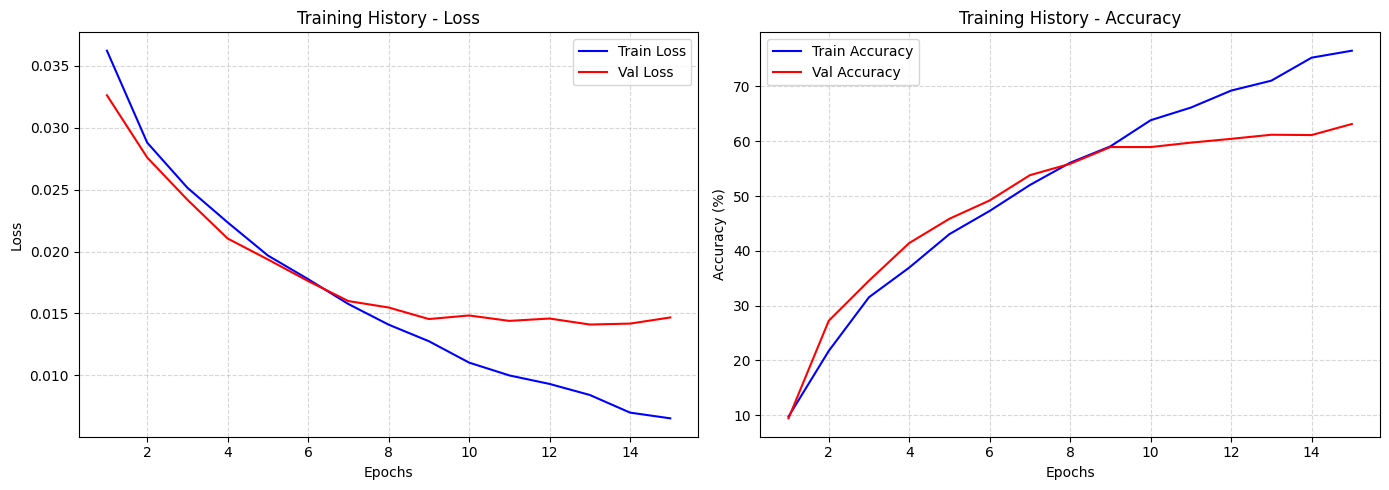

In [56]:
plot_training_history(history_model)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': criterion.__class__.__name__,
    'last_epoch_loss': history_model['val_loss'][-1],
    'last_epoch_acc': history_model['val_accuracy'][-1]
},'/kaggle/working/AlexNet_Random.pth')

In [38]:
pretrained_model = AlexNet(pretrained=True).to(device)
optimizer = Adam(pretrained_model.parameters())
criterion = nn.CrossEntropyLoss()
pretrained_model, history_pretrained_model = train_model(model=pretrained_model,
                                dataloaders={'train':train_loader, 'val':valid_loader},
                                criterion=criterion,
                                optimizer=optimizer,
                                num_epochs=15)


Epoch 1/15


55it [00:14,  3.88it/s]                        
14it [00:04,  3.47it/s]                        

Epoch 2/15



55it [00:15,  3.54it/s]                        
14it [00:04,  3.22it/s]                        

Epoch 3/15



55it [00:15,  3.55it/s]                        
14it [00:04,  3.48it/s]                        

Epoch 4/15



55it [00:13,  3.93it/s]                        
14it [00:03,  3.77it/s]                        

Epoch 5/15



55it [00:15,  3.66it/s]                        
14it [00:04,  3.36it/s]                        

Epoch 6/15



55it [00:14,  3.88it/s]                        
14it [00:03,  3.67it/s]                        

Epoch 7/15



55it [00:15,  3.48it/s]                        
14it [00:03,  3.73it/s]                        

Epoch 8/15



55it [00:15,  3.54it/s]                        
14it [00:03,  3.64it/s]                        

Epoch 9/15



55it [00:14,  3.74it/s]                        
14it [00:03,  3.80it/s]                        

Epoch 10/15



55it [00:14,  3.67it/s]                        
14it [00:03,  3.73it/s]                        

Epoch 11/15



55it [00:14,  3.79it/s]                        
14it [00:03,  3.59it/s]                        

Epoch 12/15



55it [00:15,  3.63it/s]                        
14it [00:03,  3.70it/s]                        

Epoch 13/15



55it [00:15,  3.57it/s]                        
14it [00:04,  3.41it/s]                        

Epoch 14/15



55it [00:15,  3.59it/s]                        
14it [00:04,  3.50it/s]                        

Epoch 15/15



55it [00:15,  3.58it/s]                        
14it [00:03,  3.68it/s]                        

Training complete in 4.773416058222453 minutes
Best Validation Accuracy: 61.290323


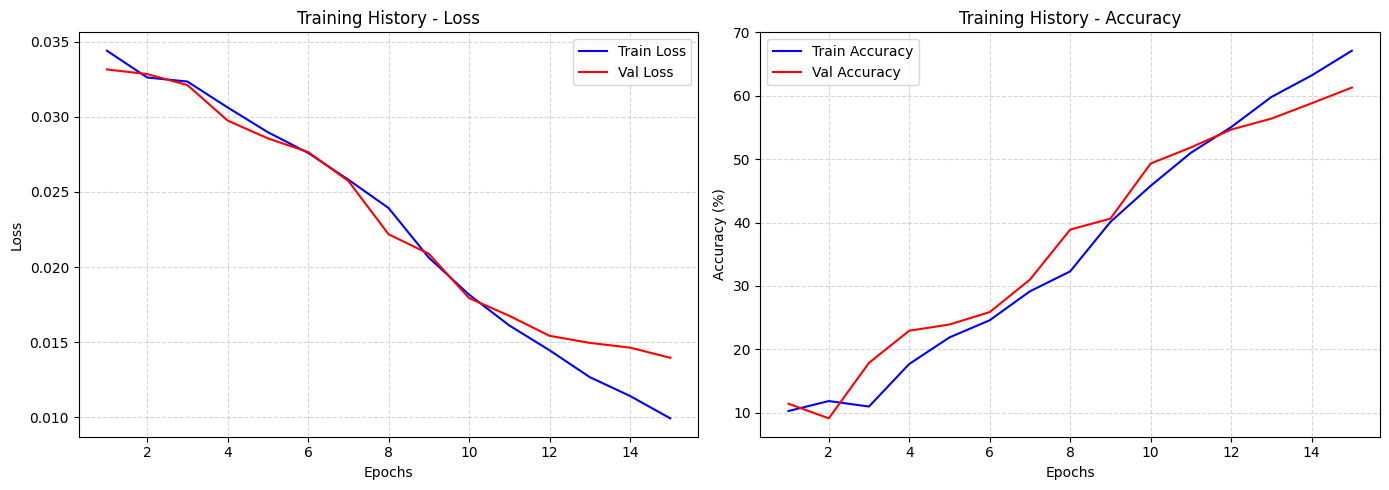

In [53]:
torch.save({
    'model_state_dict': pretrained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': criterion.__class__.__name__,
    'last_epoch_loss': history_pretrained_model['val_loss'][-1],
    'last_epoch_acc': history_pretrained_model['val_accuracy'][-1]
},'/kaggle/working/AlexNet_Pretrained.pth')
plot_training_history(history_pretrained_model)

# **Experiment 2:**
## **Compare Random Initial/Pretrained Models for Resnet18:**

In [42]:
'''
Experiment 2:
Compare Random Initial/Pretrained Models for Resnet18
'''
resnet = ResNet18(pretrained=False).to(device)
optimizer = Adam(resnet.parameters())
criterion = nn.CrossEntropyLoss()
resnet, history_resnet = train_model(model=resnet,
                                dataloaders={'train':train_loader, 'val':valid_loader},
                                criterion=criterion,
                                optimizer=optimizer,
                                num_epochs=15)
pretrained_resnet = ResNet18(pretrained=True).to(device)
optimizer = Adam(pretrained_resnet.parameters())
criterion = nn.CrossEntropyLoss()
pretrained_resnet, history_pretrained_resnet = train_model(model=pretrained_resnet,
                                dataloaders={'train':train_loader, 'val':valid_loader},
                                criterion=criterion,
                                optimizer=optimizer,
                                num_epochs=15)

Epoch 1/15


55it [00:15,  3.56it/s]                        
14it [00:04,  3.41it/s]                        

Epoch 2/15



55it [00:14,  3.68it/s]                        
14it [00:03,  3.59it/s]                        

Epoch 3/15



55it [00:16,  3.42it/s]                        
14it [00:04,  3.43it/s]                        

Epoch 4/15



55it [00:16,  3.40it/s]                        
14it [00:04,  3.48it/s]                        

Epoch 5/15



55it [00:16,  3.37it/s]                        
14it [00:04,  3.48it/s]                        

Epoch 6/15



55it [00:16,  3.33it/s]                        
14it [00:04,  3.45it/s]                        

Epoch 7/15



55it [00:16,  3.37it/s]                        
14it [00:04,  3.38it/s]                        

Epoch 8/15



55it [00:16,  3.39it/s]                        
14it [00:04,  3.37it/s]                        

Epoch 9/15



55it [00:16,  3.36it/s]                        
14it [00:04,  3.33it/s]                        

Epoch 10/15



55it [00:16,  3.40it/s]                        
14it [00:04,  3.45it/s]                        

Epoch 11/15



55it [00:16,  3.40it/s]                        
14it [00:03,  3.52it/s]                        

Epoch 12/15



55it [00:15,  3.46it/s]                        
14it [00:04,  3.16it/s]                        

Epoch 13/15



55it [00:15,  3.48it/s]                        
14it [00:04,  3.42it/s]                        

Epoch 14/15



55it [00:15,  3.49it/s]                        
14it [00:03,  3.51it/s]                        

Epoch 15/15



55it [00:15,  3.61it/s]                        
14it [00:04,  2.88it/s]                        
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training complete in 5.072221887111664 minutes
Best Validation Accuracy: 76.670507


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.4MB/s]


Epoch 1/15


55it [00:15,  3.59it/s]                        
14it [00:03,  3.56it/s]                        

Epoch 2/15



55it [00:16,  3.39it/s]                        
14it [00:04,  3.36it/s]                        

Epoch 3/15



55it [00:15,  3.54it/s]                        
14it [00:04,  3.20it/s]                        

Epoch 4/15



55it [00:15,  3.58it/s]                        
14it [00:04,  3.34it/s]                        

Epoch 5/15



55it [00:16,  3.43it/s]                        
14it [00:04,  3.20it/s]                        

Epoch 6/15



55it [00:16,  3.43it/s]                        
14it [00:04,  3.34it/s]                        

Epoch 7/15



55it [00:15,  3.59it/s]                        
14it [00:04,  3.46it/s]                        

Epoch 8/15



55it [00:15,  3.52it/s]                        
14it [00:04,  3.34it/s]                        

Epoch 9/15



55it [00:15,  3.52it/s]                        
14it [00:04,  3.42it/s]                        

Epoch 10/15



55it [00:15,  3.54it/s]                        
14it [00:03,  3.55it/s]                        

Epoch 11/15



55it [00:15,  3.46it/s]                        
14it [00:03,  3.55it/s]                        


Epoch 12/15


55it [00:15,  3.53it/s]                        
14it [00:04,  3.27it/s]                        

Epoch 13/15



55it [00:16,  3.39it/s]                        
14it [00:04,  3.17it/s]                        

Epoch 14/15



55it [00:15,  3.45it/s]                        
14it [00:04,  3.26it/s]                        

Epoch 15/15



55it [00:16,  3.37it/s]                        
14it [00:04,  3.37it/s]                        

Training complete in 5.030030830701192 minutes
Best Validation Accuracy: 89.573733


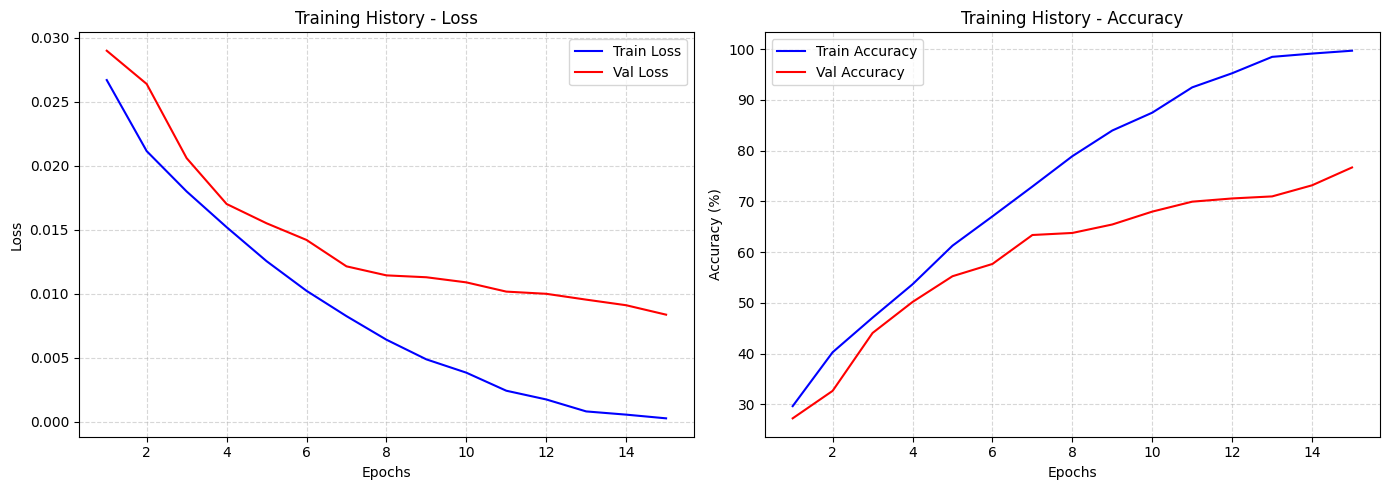

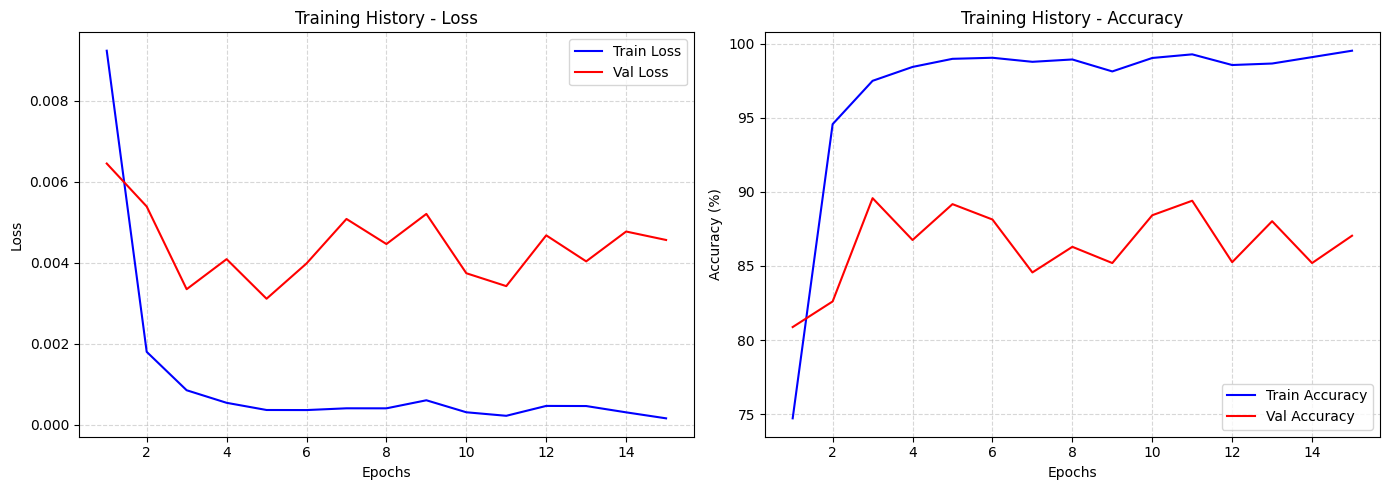

In [54]:
torch.save({
    'model_state_dict': resnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': criterion.__class__.__name__,
    'last_epoch_loss': history_resnet['val_loss'][-1],
    'last_epoch_acc': history_resnet['val_accuracy'][-1]
},'/kaggle/working/Resnet_Random.pth')
plot_training_history(history_resnet)
torch.save({
    'model_state_dict': pretrained_resnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': criterion.__class__.__name__,
    'last_epoch_loss': history_pretrained_resnet['val_loss'][-1],
    'last_epoch_acc': history_pretrained_resnet['val_accuracy'][-1]
},'/kaggle/working/Resnet_Pretrained.pth')
plot_training_history(history_pretrained_resnet)

# **Experiment 3:**
## **Compare different parameter settings:**

In [63]:
'''
Experiment 3:
Compare different parameter settings:
lr: 1e-3, 1e-4
epoch: 15, 20
model: Alexnet(Random Init)
'''
param_grid = {
    'lr': [1e-3, 1e-4],      # 学习率
    'epochs': [15, 20]       # 训练轮数
}

results = {
    'models': {},           
    'histories': {},        
    'configs': []           
}

# 双层循环遍历所有组合
for lr in param_grid['lr']:
    for num_epochs in param_grid['epochs']:
        config_name = f'lr_{lr}_epochs_{num_epochs}'
        results['configs'].append(config_name)
        
        print(f"\n=== Training with lr={lr}, epochs={num_epochs} ===")
        
        model = AlexNet().to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        model, history = train_model(
            model=model,
            dataloaders={'train': train_loader, 'val': valid_loader},
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=num_epochs
        )
        results['models'][config_name] = model
        results['histories'][config_name] = history


=== Training with lr=0.001, epochs=15 ===
Epoch 1/15


55it [00:14,  3.71it/s]                        
14it [00:03,  3.57it/s]                        

Epoch 2/15



55it [00:15,  3.55it/s]                        
14it [00:03,  3.74it/s]                        

Epoch 3/15



55it [00:14,  3.89it/s]                        
14it [00:03,  3.63it/s]                        

Epoch 4/15



55it [00:15,  3.62it/s]                        
14it [00:04,  3.42it/s]                        

Epoch 5/15



55it [00:15,  3.47it/s]                        
14it [00:03,  3.61it/s]                        

Epoch 6/15



55it [00:14,  3.70it/s]                        
14it [00:03,  3.71it/s]                        

Epoch 7/15



55it [00:15,  3.61it/s]                        
14it [00:04,  3.48it/s]                        

Epoch 8/15



55it [00:15,  3.64it/s]                        
14it [00:03,  3.66it/s]                        

Epoch 9/15



55it [00:15,  3.53it/s]                        
14it [00:03,  3.71it/s]                        

Epoch 10/15



55it [00:14,  3.84it/s]                        
14it [00:03,  3.55it/s]                        

Epoch 11/15



55it [00:14,  3.72it/s]                        
14it [00:04,  3.49it/s]                        

Epoch 12/15



55it [00:14,  3.67it/s]                        
14it [00:04,  3.50it/s]                        

Epoch 13/15



55it [00:14,  3.78it/s]                        
14it [00:04,  3.36it/s]                        

Epoch 14/15



55it [00:14,  3.68it/s]                        
14it [00:03,  3.64it/s]                        

Epoch 15/15



55it [00:14,  3.85it/s]                        
14it [00:03,  3.54it/s]                        


Training complete in 4.767467951774597 minutes
Best Validation Accuracy: 62.960829

=== Training with lr=0.001, epochs=20 ===
Epoch 1/20


55it [00:14,  3.77it/s]                        
14it [00:03,  3.54it/s]                        

Epoch 2/20



55it [00:15,  3.51it/s]                        
14it [00:03,  3.71it/s]                        

Epoch 3/20



55it [00:15,  3.66it/s]                        
14it [00:03,  3.59it/s]                        

Epoch 4/20



55it [00:14,  3.68it/s]                        
14it [00:03,  3.53it/s]                        

Epoch 5/20



55it [00:15,  3.56it/s]                        
14it [00:04,  3.32it/s]                        

Epoch 6/20



55it [00:14,  3.68it/s]                        
14it [00:04,  3.24it/s]                        

Epoch 7/20



55it [00:14,  3.83it/s]                        
14it [00:03,  3.60it/s]                        

Epoch 8/20



55it [00:14,  3.78it/s]                        
14it [00:03,  3.52it/s]                        

Epoch 9/20



55it [00:14,  3.76it/s]                        
14it [00:03,  3.63it/s]                        

Epoch 10/20



55it [00:14,  3.86it/s]                        
14it [00:03,  3.60it/s]                        

Epoch 11/20



55it [00:15,  3.58it/s]                        
14it [00:03,  3.55it/s]                        

Epoch 12/20



55it [00:14,  3.67it/s]                        
14it [00:04,  3.32it/s]                        

Epoch 13/20



55it [00:14,  3.82it/s]                        
14it [00:04,  3.32it/s]                        

Epoch 14/20



55it [00:16,  3.34it/s]                        
14it [00:04,  3.36it/s]                        

Epoch 15/20



55it [00:14,  3.77it/s]                        
14it [00:04,  3.40it/s]                        

Epoch 16/20



55it [00:14,  3.67it/s]                        
14it [00:03,  3.65it/s]                        

Epoch 17/20



55it [00:15,  3.50it/s]                        
14it [00:04,  3.41it/s]                        

Epoch 18/20



55it [00:14,  3.70it/s]                        
14it [00:03,  3.56it/s]                        

Epoch 19/20



55it [00:14,  3.79it/s]                        
14it [00:04,  3.47it/s]                        

Epoch 20/20



55it [00:14,  3.76it/s]                        
14it [00:04,  3.47it/s]                        


Training complete in 6.388602948188781 minutes
Best Validation Accuracy: 63.248848

=== Training with lr=0.0001, epochs=15 ===
Epoch 1/15


55it [00:14,  3.69it/s]                        
14it [00:04,  3.43it/s]                        

Epoch 2/15



55it [00:14,  3.86it/s]                        
14it [00:04,  3.37it/s]                        

Epoch 3/15



55it [00:15,  3.55it/s]                        
14it [00:04,  3.34it/s]                        

Epoch 4/15



55it [00:15,  3.54it/s]                        
14it [00:04,  3.44it/s]                        

Epoch 5/15



55it [00:15,  3.63it/s]                        
14it [00:03,  3.64it/s]                        

Epoch 6/15



55it [00:15,  3.65it/s]                        
14it [00:03,  3.69it/s]                        

Epoch 7/15



55it [00:14,  3.77it/s]                        
14it [00:04,  3.47it/s]                        

Epoch 8/15



55it [00:14,  3.89it/s]                        
14it [00:03,  3.66it/s]                        

Epoch 9/15



55it [00:14,  3.83it/s]                        
14it [00:04,  3.42it/s]                        

Epoch 10/15



55it [00:14,  3.68it/s]                        
14it [00:03,  3.52it/s]                        

Epoch 11/15



55it [00:15,  3.64it/s]                        
14it [00:03,  3.50it/s]                        

Epoch 12/15



55it [00:15,  3.66it/s]                        
14it [00:04,  3.33it/s]                        

Epoch 13/15



55it [00:14,  3.79it/s]                        
14it [00:03,  3.60it/s]                        

Epoch 14/15



55it [00:14,  3.68it/s]                        
14it [00:04,  3.49it/s]                        

Epoch 15/15



55it [00:15,  3.57it/s]                        
14it [00:04,  3.37it/s]                        


Training complete in 4.780614817142487 minutes
Best Validation Accuracy: 66.071429

=== Training with lr=0.0001, epochs=20 ===
Epoch 1/20


55it [00:15,  3.45it/s]                        
 54%|█████▍    | 7/13 [00:02<00:01,  3.45it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 92%|█████████▏| 12/13 [00:03<00:00,  3.42it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  Fi

Epoch 2/20



 50%|█████     | 27/54 [00:07<00:07,  3.62it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 65%|██████▍   | 35/54 [00:10<00:05,  3.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/to

Epoch 3/20



 24%|██▍       | 13/54 [00:03<00:10,  3.79it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 48%|████▊     | 26/54 [00:07<00:07,  3.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/to

Epoch 4/20



  2%|▏         | 1/54 [00:00<00:35,  1.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _sh

Epoch 5/20



  2%|▏         | 1/54 [00:00<00:35,  1.48it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

AssertionError    self._shutdown_workers(): 
can only test a child process  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shu

Epoch 6/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_w

Epoch 7/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>self._shutdown_workers()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
AssertionError
:   

Epoch 8/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_w

Epoch 9/20



 46%|████▋     | 25/54 [00:07<00:07,  3.69it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 56%|█████▌    | 30/54 [00:09<00:07,  3.05it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/to

Epoch 10/20



 17%|█▋        | 9/54 [00:02<00:13,  3.33it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 26%|██▌       | 14/54 [00:04<00:12,  3.16it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/tor

Epoch 11/20



  2%|▏         | 1/54 [00:00<00:36,  1.46it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

AssertionError  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
:     can only test a child process
self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _sh

Epoch 12/20



  2%|▏         | 1/54 [00:00<00:36,  1.44it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  4%|▎         | 2/54 [00:01<00:32,  1.61it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torc

Epoch 13/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    AssertionErrorself._shutdown_workers()
: can only test a child process  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_wo

Epoch 14/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_w

Epoch 15/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>    self._shutdown_workers()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        if w.is_alive():
self._shutdown_workers()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError
  Fi

Epoch 16/20



 20%|██        | 11/54 [00:03<00:12,  3.49it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 48%|████▊     | 26/54 [00:08<00:08,  3.39it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/to

Epoch 17/20



  6%|▌         | 3/54 [00:01<00:19,  2.61it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 15%|█▍        | 8/54 [00:02<00:15,  3.01it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torc

Epoch 18/20



  2%|▏         | 1/54 [00:00<00:33,  1.58it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _sh

Epoch 19/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>can only test a child process

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_w

Epoch 20/20



  0%|          | 0/54 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4806433ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_w

Training complete in 6.630766586462657 minutes
Best Validation Accuracy: 68.317972
